In [1]:
import random
import cupy as cp

In [2]:
class MLP:

    """
    MLP 分类算法
    """
    
    def __init__(
            self,
            hidden_size_list: list = []
    ) -> None:        
        
        """
        初始化 MLP 分类算法

        Parameters
        ----------
        hidden_size_list : 隐层规模及对应维度
        """
        
        self.hidden_size_list = hidden_size_list

    @ staticmethod
    def shuffle(
            X: cp.ndarray = None,
            y: cp.ndarray = None,
            random_seed: int = 0
    ) -> tuple[cp.ndarray, cp.ndarray]:
        
        """
        将原始数据集进行随机排序

        Parameters
        ----------
        X : 训练数据集的特征集
        y : 训练数据集的标签集
        random_seed : 随机种子

        Returns
        -------
        X : 训练数据集重排序后的特征集
        y : 训练数据集重排序后的标签集
        """
        
        random.seed(random_seed)
        index = cp.arange(len(X))
        random.shuffle(index)
        X = X[index]
        y = y[index]

        return X, y
    
    @ staticmethod
    def activate_function(X: cp.ndarray = None, activate_func: str = "sigmoid") -> cp.ndarray:

        """
        激活函数

        Parameters
        ----------
        X : 特征数据集
        activate_func : 激活函数类型

        Returns
        -------
        value : 对特征数据进行非线性变换后的取值
        """
        
        if activate_func == "sigmoid":
            value = 1 / (1 + cp.exp( - X))
        
        elif activate_func == "tanh":
            value = (cp.exp(X) - cp.exp( - X)) / (cp.exp(X) + cp.exp( - X))

        elif activate_func == "relu":
            value = cp.where(X > 0, X, 0)

        return value
    
    @ staticmethod
    def gradient(X: cp.ndarray = None, activate_func: str = "sigmoid") -> cp.ndarray:
        
        """
        激活函数的梯度

        Parameters
        ----------
        X : 特征数据集
        activate_func : 激活函数类型，可取 "sigmoid"、"tanh" 或 "relu"

        Returns
        -------
        value : 特征数据对应激活函数的梯度值
        """
        
        if activate_func == "sigmoid":
            value = X * (1 - X)
        
        elif activate_func == "tanh":
            value = 1 - X ** 2

        elif activate_func == "relu":
            value = cp.where(X > 0, 1, 0)

        return value
    
    @ staticmethod
    def softmax(y: cp.ndarray = None) -> cp.ndarray:

        """
        对神经网络的输出层中间变量进行 softmax 变换得到对应每个标签的概率值

        Parameters
        ----------
        y : 神经网络输出层的中间变量

        Returns
        -------
        vector : 变化后元素为对应每个类别概率的向量
        """
        
        vector = cp.exp(y) / cp.expand_dims(cp.sum(cp.exp(y), axis = 1), axis = 1)
        return vector
    
    def forward(
            self,
            X: cp.ndarray = None,
            layer_num: int = None,
            activate_func: str = None,
            proba: bool = True
    ) -> cp.ndarray:
        
        """
        利用 MLP 神经网络进行预测

        Parameters
        ----------
        X : 特征数据集
        layer_num : 将第 layer_num 层隐层视为输出层时的预测情况
        activate_func : 激活函数类型，可取 "sigmoid"、"tanh" 或 "relu"
        proba : 取 True 时输出向量的每一个元素为该实例对应类别的概率，取 False 时输出实例对应概率最大的类别

        Returns
        -------
        hidden_out : 算法预测值
        """

        if not activate_func:
            activate_func = self.activate_func
        
        total_layer_num = len(self.hidden_size_list)
        
        if layer_num is None:
            layer_num = total_layer_num
        
        # hidden_out 形状为 [batch_size, hidden_size_{i - 1}]
        hidden_out = X

        for i in range(layer_num):
            hidden_state = self.hidden_layer_state[i]
            
            # 权重矩阵 hidden_layer_weight 形状为 [hidden_size_{i}, hidden_size_{i - 1}]
            # 偏置向量 hidden_layer_bais 形状为 hidden_size_{i}
            hidden_layer_weight = hidden_state[0]
            hidden_layer_bais = hidden_state[1]
            
            # 扩充 hidden_out 维度，形状为 [batch_size, 1, hidden_size_{i - 1}]
            hidden_out = cp.expand_dims(hidden_out, 1)
            # z 形状为 [batch_size, hidden_size_{i}]
            ## hidden_layer_weight * hidden_out 形状为 [batch_size, hidden_size_{i}, hidden_size_{i - 1}]
            ## cp.sum(hidden_layer_weight * hidden_out, axis = -1) 形状为 [batch_size, hidden_size_{i}]
            z = cp.sum(hidden_layer_weight * hidden_out, axis = -1) + hidden_layer_bais

            if i < total_layer_num - 1:
                hidden_out = self.activate_function(z, activate_func)
            else:
                hidden_out = self.softmax(z)
        
        if layer_num == total_layer_num:
            if not proba:
                hidden_out = cp.array([self.class_[cp.argmax(i)] for i in hidden_out])

        return hidden_out
    
    def backward(self, x: cp.ndarray = None, y: cp.ndarray = None, activate_func: str = "sigmoid", lr: float = 0.01) -> cp.ndarray:

        """
        反向传播更新算法参数

        Parameters
        ----------
        x : 训练数据集的特征集，形状为 [batch_size, icput_size]
        y : 训练数据集的标签集，形状为 [batch_size, output_size]
        activate_func : 激活函数的类型，可取 "sigmoid"、"tanh" 或 "relu"
        lr : 学习率

        Returns
        -------
        delta:
        """
        
        # 输出层的 delta 误差, 形状为 [batch_size, hidden_size_{i}]
        delta = self.forward(x, activate_func = activate_func) - y
        
        # 反向更新第 i 层隐层的参数
        for i in range(len(self.hidden_layer_state) - 1, -1, -1):

            # 前向传播计算第 i 层隐层的输出，形状为 [batch_size, hidden_size_{i - 1}]
            hidden_out = self.forward(x, i, activate_func)
            # 扩充隐层输出的维度，形状为 [batch_size, 1, hidden_size_{i - 1}]
            hidden_out = cp.expand_dims(hidden_out, axis = 1)
            
            # 计算参数矩阵和偏置
            ## 扩充 delta 误差的维度，形状为 [batch_size, hidden_size_{i}, 1]
            ## delta * hidden_out 的形状为 [batch_size, hidden_size_{i}, hidden_size_{i - 1}]
            ## 参数矩阵的形状为 [hidden_size_{i}, hidden_size_{i - 1}]
            bais_grad = cp.mean(delta, axis = 0)
            delta = cp.expand_dims(delta, axis = 2)
            weight_grad = cp.mean(delta * hidden_out, axis = 0)
            
            # 压缩隐层输出的维度，形状为 [batch_size, hidden_size_{i - 1}]
            hidden_out = hidden_out.squeeze(1)
            # 压缩 delta 误差的维度，形状为 [batch_size, hidden_size_{i}]
            delta = delta.squeeze(2)

            # 提取更新前的第 i 层隐层参数
            hidden_state = self.hidden_layer_state[i]
            hidden_layer_weight = hidden_state[0]
            hidden_layer_bais = hidden_state[1]
            
            # 更新第 i 层隐层的参数
            ## 参数矩阵 hidden_layer_weight 的形状为 [hidden_size_{i}, hidden_size_{i - 1}] 
            ## 偏置向量 hidden_layer_bais 的形状为 hidden_size_{i}
            hidden_layer_weight -= lr * weight_grad
            hidden_layer_bais -= lr * bais_grad

            hidden_state = [hidden_layer_weight, hidden_layer_bais]

            self.hidden_layer_state[i] = hidden_state
            
            # 更新 delta 误差得到第 i - 1 层的 delta 误差
            ## A 形状为 [batch_size, hidden_size_{i - 1}]
            ## B 形状为 [batch_size, hidden_size_{i - 1}]
            ## B.T * A.T 形状为 [batch_size, hidden_size_{i - 1}]
            ## delta 误差形状为 [batch_size, hidden_size_{i - 1}] 
            A = self.gradient(hidden_out, activate_func)
            B = delta @ hidden_layer_weight
            delta = B * A
    
    def fit(
            self,
            X: cp.ndarray = None,
            y: cp.ndarray = None,
            lr: float = 0.1,
            activate_func: str = "sigmoid",
            batch_size: int = 128,
            epoch_num: int = 100,
            random_seed: int = 0
    ) -> None:
        
        """
        拟合训练数据集

        Parameters
        ----------
        X : 训练数据集的特征集
        y : 训练数据集的标签集
        lr : 学习率
        activate_func : 激活函数的类型，可取 "sigmoid"、"tanh" 或 "relu"
        batch_size : 随机梯度下降法更新参数时每一批数据集包含的数据量
        epoch_num : 迭代次数
        random_seed : 随机数种子
        """

        self.activate_func = activate_func
        # 训练数据集重排序，X 形状为 [n_sample, icput_size]，y 形状为 n_sample
        X, y = self.shuffle(X, y, random_seed)
        
        self.loss = list()
        size = len(y)

        # 利用标签数据集构造 one-hot 向量
        ## y_ 形状为 [n_sample, output_size]
        self.class_ = cp.unique(y)
        self.class_num = len(self.class_)
        y_ = cp.zeros((size, self.class_num))
        
        for i in range(len(self.class_)):
            y_[y == self.class_[i], i] = 1
        
        # 初始化每层隐层的参数后传入 hidden_layer_state
        self.hidden_layer_state = list()
        dim = X.shape[1]
        
        for hidden_size in self.hidden_size_list:
            
            # 权重矩阵 hidden_layer_weight 形状为 [hidden_size_{i}, hidden_size_{i - 1}]
            # 偏置向量 hidden_layer_bais 形状为 hidden_size_{i}
            hidden_layer_weight = cp.random.normal(0, 1, (hidden_size, dim))
            hidden_layer_bais = cp.random.normal(0, 1, hidden_size)

            self.hidden_layer_state.append([hidden_layer_weight, hidden_layer_bais])
            dim = hidden_size

        # 拟合训练数据，采用随机梯度下降法更新算法参数
        batch_num = len(X) // batch_size
        X = cp.array_split(X, batch_num) # X 形状为 [batch_num, batch_size, icput_size]
        y_ = cp.array_split(y_, batch_num) # y_ 形状为 [batch_num, batch_size, output_size]
        
        epoch = 0
        while True:
            
            loss = 0
            for x, y in zip(X, y_):
                
                # 反向传播更新算法参数
                ## X 形状为 [batch_size, icput_size]
                ## y 形状为 [batch_size, output_size]
                self.backward(x, y, activate_func, lr)
                # 前向传播计算预测值，形状为 [batch_size, output_size]
                pred = self.forward(x, activate_func = activate_func)
                # 评估算法
                loss += self.eval(pred, y).get()

            self.loss.append(loss / batch_num)

            epoch += 1

            if epoch == epoch_num:
                break
    
    @ staticmethod
    def eval(y_hat: cp.ndarray = None, y: cp.ndarray = None) -> float:
        
        """
        评估函数，评估损失函数值

        Paramters
        ---------
        y_hat : 标签预测值
        y : 数据集的标签集

        Returns
        -------
        loss : 损失函数值
        """
        
        loss = - cp.mean(cp.mean(y * cp.log(y_hat), axis = 1))
        return loss

In [3]:
import numpy as np
import pandas as pd

data = pd.read_csv("D:\犯罪预测建模\数据集\社区犯罪数据集\社区犯罪数据集.csv", sep = ",", header = 0, index_col = 0)
data["ViolentCrimesPerPop"] = np.where(data["ViolentCrimesPerPop"] > 0.1, 1, 0) # 犯罪率高于 0.1% 的社区被标记为犯罪高发社区
data = data.iloc[:, 2:]
data.head(5)

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
state,,,,,,,,,,,,,,,,,,,,,
1,0.01,0.61,0.21,0.83,0.02,0.01,0.41,0.49,0.26,0.21,...,0.03,0.70,0.40,0.34,0.57,0.05,0.06,0.01,0.0,0
1,0.01,0.41,0.55,0.57,0.01,0.00,0.47,0.45,0.31,0.57,...,0.00,0.93,0.66,0.82,0.84,0.11,0.03,0.01,0.0,1
1,0.03,0.34,0.86,0.30,0.04,0.01,0.41,0.42,0.27,0.59,...,0.04,0.77,0.59,0.70,0.64,0.06,0.11,0.04,0.0,1
1,0.01,0.38,0.35,0.71,0.04,0.01,0.39,0.46,0.31,0.49,...,0.03,0.78,0.56,0.67,0.71,0.09,0.05,0.00,0.0,1
1,0.04,0.37,0.32,0.70,0.21,0.02,1.00,1.00,1.00,0.14,...,0.12,0.49,0.12,0.00,0.15,0.09,0.09,0.01,0.0,1


In [4]:
X_train = cp.array(data.iloc[:-300, :-1].values)
y_train = cp.array(data.iloc[:-300, -1].values)

mlp = MLP([128, 28, 2]) # 实例化 MLP 算法
mlp.fit(X_train, y_train, lr = 0.001, epoch_num = 100, activate_func = "sigmoid") # 拟合训练样本
sigmoid_loss = mlp.loss
mlp.fit(X_train, y_train, lr = 0.001, epoch_num = 100, activate_func = "tanh") # 拟合训练样本
tanh_loss = mlp.loss
mlp.fit(X_train, y_train, lr = 0.001, epoch_num = 100, activate_func = "relu") # 拟合训练样本
relu_loss = mlp.loss

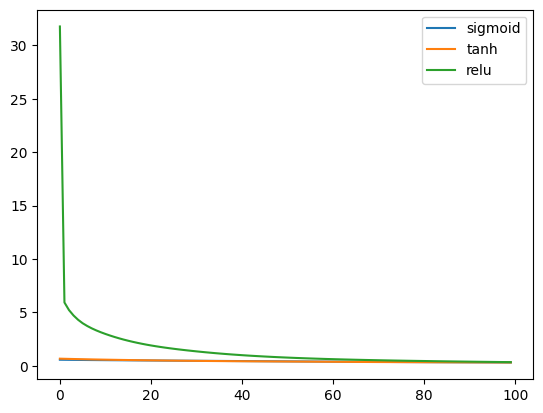

In [5]:
import matplotlib.pyplot as plt
plt.plot(sigmoid_loss)
plt.plot(tanh_loss)
plt.plot(relu_loss)
plt.legend(["sigmoid", "tanh", "relu"])

In [6]:
mlp.fit(X_train, y_train, lr = 0.001, epoch_num = 100, activate_func = "sigmoid") # 拟合训练样本
sigmoid_loss1 = mlp.loss

mlp.fit(X_train, y_train, lr = 0.01, epoch_num = 100, activate_func = "sigmoid") # 拟合训练样本
sigmoid_loss2 = mlp.loss

mlp.fit(X_train, y_train, lr = 0.1, epoch_num = 100, activate_func = "sigmoid") # 拟合训练样本
sigmoid_loss3 = mlp.loss

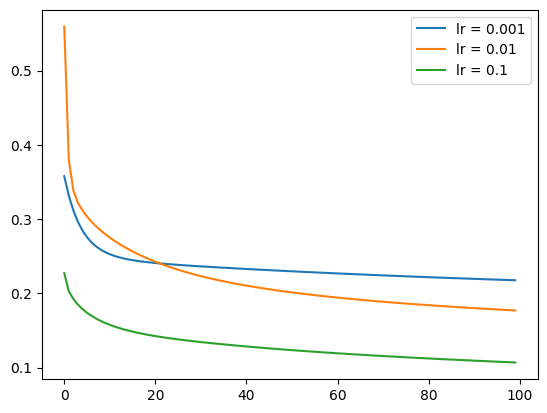

In [7]:
plt.plot(sigmoid_loss1)
plt.plot(sigmoid_loss2)
plt.plot(sigmoid_loss3)
plt.legend(["lr = 0.001", "lr = 0.01", "lr = 0.1"])

In [8]:
mlp.fit(X_train, y_train, lr = 0.1, epoch_num = 100, activate_func = "sigmoid") # 拟合训练样本

X_valid = cp.array(data.iloc[:-300, :-1].values)
y_valid = cp.array(data.iloc[:-300, -1].values)

pred = mlp.forward(X_valid, proba = False)
sum(pred == y_valid) / len(pred)

array(0.83106911)